# The Runge-Kutta Method, Higher-Order ODEs and Multistep Methods

Let's follow-up the discussion of the Euler Method by moving to a higher order in the expansion. THe name of this algorithm, as we discussed in [Lecture 10](https://github.com/UChicagoPhysics/PHYS250/tree/master/Slides/Lecture10), this is the classical Runge-Kutta method. With these examples, we will go beyond first-order ODEs, and take a first look at multistep methods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/matplotlib/font_manager.py:1435: MatplotlibDeprecationWarning: matplotlib.verbose is deprecated;
Command line argument --verbose-LEVEL is deprecated.
This functionality is now provided by the standard
python logging library.  To get more (or less) logging output:
    import logging
    logger = logging.getLogger('matplotlib')
    logger.set_level(logging.INFO)
/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:356: MatplotlibDeprecationWarning: matplotlib.verbose is deprecated;
Command line argument --verbose-LEVEL is deprecated.
This functionality is now provided by the standard
python logging library.  To get more (or less) logging output:
    import logging
    logger = logging.getLogger('matplotlib')
    logger.set_level(logging.INFO)
  if self.ge(level):


## Introduction

In the previous example, we looked at the Explicit Euler method (aka the First Order Runge-Kutta Method), and checked that it had a global order of accuracy $\mathcal{O}(h^1)$. Now we'll again take an ODE $y' = f(x,y)$ with an initial condition $y(x_0) = y_0$ and look at more advanced numerical methods for solving the problem.

## The Runge-Kutta Method

For the Explicit Euler method we truncated the Taylor expansion after the linear term. It's clear that including more terms before truncation will give us a higher-order (i.e. *better*) approximation! 

### Runge-Kutta Method in more detail

As we discussed in Lecture, the genius of the Runge-Kutta method is to realize that was using two estimates of the slope (i.e., Second Order Runge Kutta; using slopes at the beginning and midpoint of the time step, or using the slopes at the beginninng and end of the time step) gives an approximation with greater accuracy than using just a single slope (i.e., First Order Runge Kutta; using only the slope at the beginning of the interval). 

It seems reasonable, then, to assume that using even more estimates of the slope would result in even more accuracy. It turns out this is true, and leads to higher-order Runge-Kutta methods. Third order methods can be developed (but are not discussed here). Instead we will restrict ourselves to the much more commonly used Fourth Order Runge-Kutta technique, which uses four approximations to the slope. It is important to understand these lower order methods before starting on the fourth order method.

### Second Order Runge-Kutta Method

Extrapolating from the First Order method (i.e. the Explicit Euler Method), it's clear that we need the Taylor Series terms:

$$
\begin{align}
f(x+h) &= f(x) + hf^{\prime}(x) + \frac{h^2}{2!}f^{\prime\prime}(x) + \frac{h^3}{3!}f^{\prime\prime\prime}(x)+\frac{h^4}{4!}f^{\prime\prime\prime\prime}(x) + \cdots \\
f(x-h) &= f(x) - hf^{\prime}(x) + \frac{h^2}{2!}f^{\prime\prime}(x) - \frac{h^3}{3!}f^{\prime\prime\prime}(x)+\frac{h^4}{4!}f^{\prime\prime\prime\prime}(x) + \cdots \\
\end{align}
$$


If we put the these together, we get the *finite central sum and difference* approximations:

$$
\begin{align}
f(x+h) + f(x-h)   &= 2f(x) + h^2f^{\prime\prime}(x) + \frac{h^4}{12}f^{\prime\prime\prime\prime}(x) + \cdots \\
f(x+h) - f(x-h)   &= 2hf^{\prime}(x) + \frac{h^3}{3}f^{\prime\prime\prime}(x) +  \cdots \\
\end{align}
$$

In the case of the finite central difference approximation, the *global error* on the approximation to $f^{\prime}(x)$ is given as:

$$
f^{\prime}(x) - \frac{f(x+h) - f(x-h)}{2h} = -\frac{h^2}{6}f^{\prime\prime\prime}(x) +  \cdots
$$

This represents an accuracy of $\mathcal{O}(h^2)$, which is an order of magnitude better than Explicit Euler!

If we now go back to our finite difference *step* from the Euler Method discussion, and expand about the *midpoint* of the integration interval (that is, make use of the improved precision of the finite *central* difference approximation to $f$) then we have:

$$
y_{n+1} \approx y_n + hf(x_{n+1/2}, y_{n+1/2})  + \mathcal{O}(h^2)
$$

and so our sequence of approximation points $y_n$ is calculated as

$$
y_{n+1} \simeq y_n + hf(x_{n+1/2}, y_{n+1/2}).
$$

The price for improved precision is having to evaluate the derivative function and $y$ at the middle of the interval, $x_{n+1/2} = x_n + h/2$. And there's the rub: we don't know the value of $y_{n+1/2}$ and cannot use this algorithm to determine it.
  
The way out of this issue is to use Euler's algorithm for $y_{n+1/2}$:

$$
y(x + h/2) = y_n + \frac{1}{2}hy^{\prime} = y_n + \frac{1}{2}hf(x_n,y_n)
$$

In this way, the known derivative function $f$ is evaluated at the ends and the midpoint of the interval, but that only the (known) initial value of the dependent variable $y$ is required. This makes the algorithm self-starting.

$$
y_{n+1} \simeq y_n + k_2 
$$

where

$$
\begin{align}
k_1 &= hf(x_n, y_n), \\
k_2 &= hf(x_n + \frac{h}{2}, y_{n} + \frac{k_1}{2})
\end{align}
$$


### Implementing the RK2 Method in Python

Just like we did with the Explicit Euler method, we'll define a function to implement the SEcond Order Runge-Kutta method for a first-order ODE system.

In [2]:
def RungeKutta2(func, y_0, x, args={}):
    """ Second Order Runge-Kutta (RK2) approximation to a first-order ODE system
    with initial conditions.

    Args:
        func: (callable) The first-order ODE system to be approximated.
        y_0:  (array)    The initial condition.
        t:    (array)    A sequence of time points for which to solve for y.
        args: (dict)     Extra arguments to pass to function.

    Out:
        y:    (array)    The approximated solution of the system at each time in t,
                         with the initial value y_0 in the first row.
    """

    # Initialise the approximation array
    y = np.zeros([len(x), len(y_0)])
    y[0] = y_0

    # Loop through the time steps, approximating this step from the prev step
    for i, x_i in enumerate(x[:-1]):

        h = x[i+1] - x_i # size of the step

        k_1 = h*func(x_i, y[i], args)
        k_2 = h*func(x_i + h/2. , y[i] + k_1/2., args)

        y[i+1] = y[i] + k_2 # RK2 step

    return y

### Test function: Exponential

We'll define our test function `exp` just as we did in Part 1.

In [3]:
def exp(x, y, args):
    """ An exponential function described as a first-order ODE. """
    
    dydx = args['a']*y
    return dydx

### Plot the result for RK2

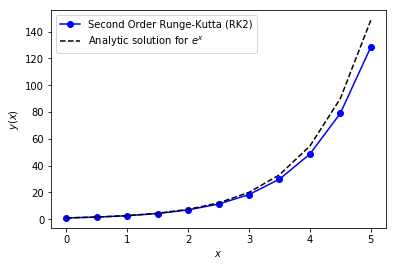

In [4]:
y_0 = np.array([1.]) # Initial condition

N     = 10 # Num of steps to take
x_max = 5. # Limit of the range to evaluate the function
x     = np.linspace(0., x_max, N+1) # Array of discretized steps

solve_args = {'a':1}

y = RungeKutta2(exp, y_0, x, solve_args) # Solve the ODE with Explicit Euler

plt.plot(x, y[:,0], 'b-o', label='Second Order Runge-Kutta (RK2)')
plt.plot(x, np.exp(solve_args['a']*x), 'k--', label='Analytic solution for $e^{x}$')
plt.xlabel(r'$x$')
plt.ylabel(r'$y(x)$')
plt.legend(loc=2)

plt.show()


### The Fourth Order Runge-Kutta Method

The classical Runge-Kutta method does just this, up to an order of accuracy $\mathcal{O}(h^4)$ — 3 orders higher than Explicit Euler! We're not going to derive the approximation here but you can look it up if you're interested. 

The finite difference step in this case is given by

$$
y_{n+1} = y_n + \tfrac{1}{6} \left( k_1 + 2k_2 + 2k_3 + k_4 \right),
$$

where 

$$
\begin{align}
k_1 &= hf(x_n, y_n), \\
k_2 &= hf(x_n + \tfrac{h}{2}, y_n + \tfrac{k_1}{2}), \\
k_3 &= hf(x_n + \tfrac{h}{2}, y_n + \tfrac{k_2}{2}), \\
k_4 &= hf(x_n + h, y_n + k_3).
\end{align}
$$


### Implementing the Method in Python

Just like we did with the Explicit Euler and RK2 methods, we'll define a function to implement the Fourth Order Runge-Kutta method for a first-order ODE system.

In [5]:
def RungeKutta4(func, y_0, x, args={}):
    """ Classical Runge-Kutta (RK4) approximation to a first-order ODE system
    with initial conditions.

    Args:
        func: (callable) The first-order ODE system to be approximated.
        y_0:  (array)    The initial condition.
        t:    (array)    A sequence of time points for which to solve for y.
        args: (dict)     Extra arguments to pass to function.

    Out:
        y:    (array)    The approximated solution of the system at each time in t,
                         with the initial value y_0 in the first row.
    """

    # Initialise the approximation array
    y = np.zeros([len(x), len(y_0)])
    y[0] = y_0

    # Loop through the time steps, approximating this step from the prev step
    for i, x_i in enumerate(x[:-1]):

        h   = x[i+1] - x_i # size of the step

        k_1 = h*func(x_i, y[i], args)
        k_2 = h*func(x_i + h/2. , y[i] + k_1/2., args)
        k_3 = h*func(x_i + h/2. , y[i] + k_2/2., args)
        k_4 = h*func(x_i + h    , y[i] + k_3, args)

        y[i+1] = y[i] + 1/6.*(k_1 + 2.*k_2 + 2.*k_3 + k_4) # RK4 step

    return y

### Plot the result for RK4

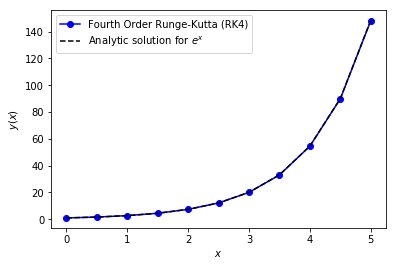

In [6]:
y = RungeKutta4(exp, y_0, x, solve_args) # Solve the ODE with Explicit Euler

plt.plot(x, y[:,0], 'b-o', label='Fourth Order Runge-Kutta (RK4)')
plt.plot(x, np.exp(solve_args['a']*x), 'k--', label='Analytic solution for $e^{x}$')
plt.xlabel(r'$x$')
plt.ylabel(r'$y(x)$')
plt.legend(loc=2)

plt.show()

### Checking Accuracy

We'll define our test function `exp` just as we did in Part 1.

In [7]:
def exp(x, y, args):
    """ An exponential function described as a first-order ODE. """
    
    dydx = args['a']*y
    return dydx

And just as we did for the Explicit Euler, we'll use this test function to check the order of accuracy of the method by looking over a wide range of stepsizes.

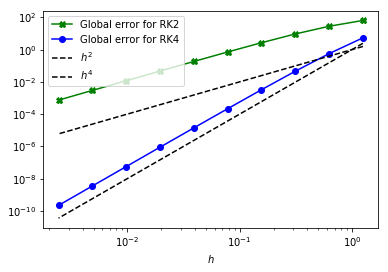

In [8]:
y_0 = np.array([1.]) # Initial condition

solve_args = {}
solve_args['a'] = 1.

t_max = 5.

# Range of stepsizes
max_N = 12
N = 2**np.arange(2, max_N) # N = 2, 4, 8, ..., 2^max_N

y_end_rk2 = np.zeros(len(N))    # array to fill with the final values
y_end_rk4 = np.zeros(len(N))    # array to fill with the final values
stepsize  = np.zeros(len(N))    # array to fill with the stepsizes

for i, N_i in enumerate(N): # loop over different numbers of steps

    t = np.linspace(0., t_max, N_i+1)
    
    y_end_rk2[i] = RungeKutta2(exp, y_0, t, solve_args)[-1]
    y_end_rk4[i] = RungeKutta4(exp, y_0, t, solve_args)[-1]
    
    stepsize[i] = t_max/N_i
    
plt.loglog(stepsize, abs(y_end_rk2 - np.exp(solve_args['a']*t_max)), 'g-X', label='Global error for RK2')

plt.loglog(stepsize, abs(y_end_rk4 - np.exp(solve_args['a']*t_max)), 'b-o', label='Global error for RK4')


# Plot the h^2 error
plt.loglog(stepsize, stepsize**2,'k--', label=r'$h^2$')

# Plot the h^4 error
plt.loglog(stepsize, stepsize**4,'k--', label=r'$h^4$')

# Label the x-axis
plt.xlabel(r'$h$')

# Move the legend to the upper left
plt.legend(loc=2)

So we've confirmed that the Runge-Kutta method is $\mathcal{O}(h^4)$ – so that the global error gets smaller much quicker with increased number of steps than the Explicit Euler.

## Example 2: A Forced and Damped Pendulum

The next problem we're going to look at is a second-order ODE, but crucially _any higher-order ODE can be rewritten as a set of coupled first-order equations_, such that we can apply the solvers we've already designed. We'll see how to do that with this example.

### The Physical Problem

Take an idealised pendulum: a weightless string of length $\ell$, fixed at one end with a mass $m$ at the other. The pendulum is free to swing in a plane subject to gravity, friction proportional to its velocity $v$, and may be driven by an external periodic force $F_d \cos {\omega_d t}$.

We start with Newton's second law applied to the horizontal displacement $x$ for the unforced and undamped pendulum,

$$m\ddot{x} = -mg \sin{\theta}$$

where $g$ is the local acceleration due to gravity and $\theta{(t)}$ is the angle of displacement of the string from vertical at time $t$. We now apply a frictional force proportional to the translational velocity and rearrange to obtain a second-order homogeneous differential equation,

$$ m \ddot{x} + k \ell \dot{x} + mg \sin{\theta} = 0 $$

where $k$ is the coefficient of friction.

We want to consider angular displacement, so substitute $\dot{x} = \ell \dot{\theta}$ and $\ddot{x} = \ell \ddot{\theta}$, and now apply the driving force 

$$ m \ell \ddot{\theta} + k \ell \dot{\theta} + mg \sin{\theta} = F_d \cos {\omega_d t} $$

The equation is nonlinear (due to the sine function), so finding an analytic solution is going to be difficult. Numerical methods are the next line of attack, so we'll try our Runge-Kutta method on the problem. First we must rewrite the second-order equation as a set of coupled first-order equations. Let $y_0 = \theta$, $y_1 = \dot{\theta}$ and $y_2 = \ddot{\theta}$. Then 

$$ 
\begin{align*}
y_0' &= y_1 = \dot{\theta} \\
y_1' &= y_2 = \ddot{\theta} = -\frac{k}{m}\dot{\theta} - \frac{g}{\ell} \sin{\theta} + \frac{F_d}{m \ell} cos{\omega_d t}
\end{align*}
$$
    
is the system we want. We make a final tidying of the parameters by letting $\alpha = g/\ell$, $\beta = k/m$ and $\gamma = F/m\ell$

$$
\begin{align*}
y_0' &= y_1 \\
y_1' &= -\alpha \sin{y_0} -\beta y_1 + \gamma \cos{\omega t}
\end{align*}
$$

### Setting up the Problem in Python

We write this pair of euqations up as a Python function to be passed to our ODE integrator:

In [9]:
def pendulum(t, y, args):
    """ A damped and forced pendulum, described as set of two first-order ODEs.

    Args:
        t: Time
        y: Pendulum system vector [angle, angular velocity] 
        args['alpha']: gravity_acc/length_of_pendulum
        args['beta']: friction_constant/mass_pendulum
        args['gamma']: driving_force/mass_pendulum/length_pendulum
        args['omega']: driving_freq

    Returns:
        dydt: ODE vector
    """

    dydt = np.zeros(2)

    dydt[0] = y[1]
    dydt[1] = (-args['alpha']*np.sin(y[0]) - args['beta']*y[1] + 
                args['gamma']*np.cos(args['omega']*t))

    return dydt

Now we're ready to select some parameters. First we'll remove friction ($k = 0$) and apply no driving force ($F_d = 0$), under which conditions we expect to see simple harmonic motion of the pendulum back and forth.

In [10]:
### Parameters

gravity_acc = 10. # [m /s2]

length_pendulum = 1. # [m]
mass_pendulum = 1. # [kg]
friction_constant = 0. # [kg /m /s]

driving_force = 0. # [N]
driving_freq = 0. # [2π /s]

N = 200

t = np.linspace(0., 10., N+1) # [s] an array of time steps

We're going to pass the arguments to the solver as a dict, so let's make that now.

In [11]:
solve_args = {}
solve_args['alpha'] = gravity_acc/length_pendulum
solve_args['beta'] = friction_constant/mass_pendulum
solve_args['gamma'] = driving_force/mass_pendulum/length_pendulum
solve_args['omega'] = driving_freq

Next we need some initial conditions. We'll pick $\theta_0 = \tfrac{\pi}{8}$ so that we can check our numerical result with the **small angle approximation**, 

$$\sin \theta \approx \theta.$$

With this approximation, the undamped and unforced solution can be found analytically: $y = y_0 \cos (\sqrt{\alpha} t)$ (you can check this by substituting it into the original ODE).

In [12]:
initial_ang = np.pi/8 # [rad]
initial_ang_vel = 0. # [rad /s]

initial_cond = np.array([initial_ang, initial_ang_vel])

### Solving the Problem

Now we can solve the ODE system using the Runge-Kutta method we made above and plot the angle $y_0$ over time.

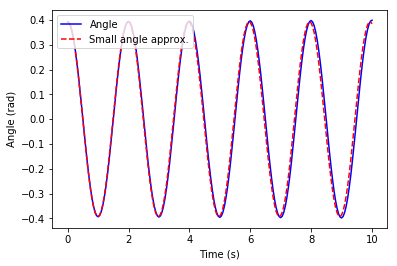

In [13]:
from scipy.integrate import odeint

# y = odeint(pendulum, initial_cond, t, args=(solve_args,))

# Solve Pendulum ODE with RK2 or RK4
y = RungeKutta2(pendulum, initial_cond, t, solve_args)

y_small_ang = initial_ang*np.cos(np.sqrt(solve_args['alpha'])*t)

plt.plot(t, y[:,0], c='b', label='Angle')
plt.plot(t, y_small_ang, 'r--', label='Small angle approx.')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend(loc=2)

So we see that the pendulum oscillates as expected and the frequency matches the known small angle result reasonably well for a few swings. (Subject to the error in the small angle approximation. Try making `initial_ang` bigger or smaller to see where the approximation works well.)

Other perspectives we might be interested in are the the pendulum's trajectory in phase space, which we plot in a **phase diagram** and its spectral properties, via a **power spectrum**. We'll plot those now.

In [14]:
def plot_pendulum(t,y):
    """ Plot Angle, Phase Diagram, FFT. """
    
    fig = plt.figure()

    # Plot Angle
    ax_1 = fig.add_subplot(211)
    ax_1.plot(t, y[:,0], c='b')
    ax_1.set_xlabel('Time (s)')
    ax_1.set_ylabel('Angle (rad)')
    
    # Plot Phase Diagram
    ax_2 = fig.add_subplot(223)
    ax_2.plot(y[:,0], y[:,1], c='g')
    ax_2.set_xlabel('Angle (rad)')
    ax_2.set_ylabel('Angular Velocity (rad /s)')
    
    # Fourier Transform
    f_fft = np.fft.fftfreq(len(t), t[1]-t[0])
    y_fft = np.fft.fft(y[:,0])/np.sqrt(2*len(t))
    
    # Plot Power Spectrum
    ax_3 = fig.add_subplot(224)
    ax_3.plot(f_fft[:N/2]*2*np.pi, abs(y_fft[:N/2]), c='r')
    ax_3.set_xlim([0, 30])
    ax_3.set_xlabel('Ang Freq ($2 \pi$ Hz)')
    ax_3.set_ylabel('Power')

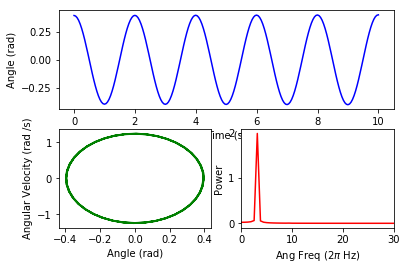

In [15]:
plot_pendulum(t,y)

The phase diagram (green, bottom left) shows each possible physical state for the system. We see the undamped, unforced pendulum follows a regular orbit. The power spectrum (red, bottom right) is found by taking a discrete Fourier transform using NumPy's `fftpack` module. We see a single narrow peak at $\omega \approx \sqrt{\alpha}$, the pendulum's natural frequency.

### Adding Friction

To better model a physical pendulum we might add a friction constant $k$, and see what happens when we solve the system with this included.

In [16]:
friction_constant = .5 # [kg /m /s]
solve_args['beta'] = friction_constant/mass_pendulum

# Solve Pendulum ODE with RK4
y = ode_int_rk(pendulum, initial_cond, t, solve_args)

plot_pendulum(t,y)

NameError: name 'ode_int_rk' is not defined

We see that over time the friction attenuates the pendulum's swing. The phase space trajectory no longer orbits consistently but spirals in, and the spectral peak has been widened out to include a spread of lower frequency components.

### Adding a Driving Force

In [ ]:
driving_force = 10. # [N]
driving_freq = 10. # [2π /s]

solve_args['gamma'] = driving_force/mass_pendulum/length_pendulum
solve_args['omega'] = driving_freq

# Solve Pendulum ODE with RK4
y = ode_int_rk(pendulum, initial_cond, t, solve_args)

plot_pendulum(t,y)

The driven system is of course more interesting! The phase space trajectory looks chaotic, but the pendulum's behaviour is clear in the power spectrum, where we see we now have an additional peak at $\omega_F$.

Anyway, there's plenty interesting to explore in the damped forced pendulum system, but as we're just interested in the integration methods here, we'll move on. The takeaway is: by converting our second-order ODE into a system of first-order ODEs, we are able to solve it using the methods we've already written. And crucially, this can be done for any higher-order ODE.